# Visualize the output of the Convolutinal Layers
* [prepare test set](#1)
* [import a CNN model for MNIST and make prediction](#2)
* [visulize the Convolutional layers output](#3)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
mnist = tf.keras.datasets.mnist
from tensorflow import keras

## create a test dataset <a class='anchor' id = '1'></a>

In [2]:
def create_data_sets(n):

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train/255, x_test/255
    
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation]
    y = y[permutation]
    
    return x[:n], y[:n]

shape of train set (2000, 28, 28), (2000,)
shape of test set (2000, 28, 28), (2000,)


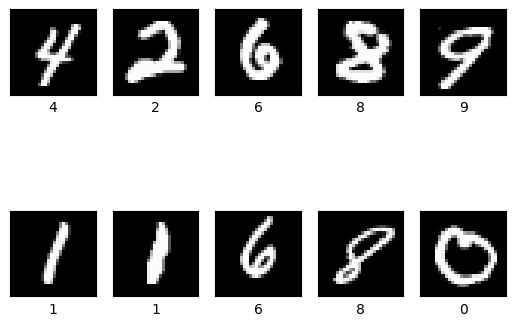

In [3]:
# create and inspect the data sets
n = 2*10**3
x, y = create_data_sets(n)

print(f'shape of train set {x.shape}, {y.shape}')
print(f'shape of test set {x.shape}, {y.shape}')

# plot some training examples
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i],
               cmap= 'gray'
               )
    plt.xlabel(f'{y[i]}')
    plt.xticks(())
    plt.yticks(())

In [4]:
# embed the data from 28x28 pixels to 50x50 pixels by randomly placing the image

def embedding(img, l_original = 28,  l_embed = 50):

    # pick two random integers to represent the position of the top left pixel of the image
    pos_x, pos_y = np.random.randint(l_embed-l_original, size=2) 
    embed_img = np.zeros((l_embed, l_embed))
    embed_img[pos_x:pos_x+l_original, pos_y:pos_y+l_original] = img

    return embed_img

shape of the embedded training set (2000, 50, 50)


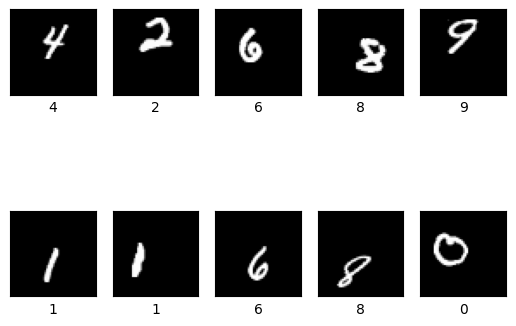

In [5]:
x_embedded = np.array([embedding(img) for img in x])
print(f'shape of the embedded training set {x_embedded.shape}')

# plot some embedded training examples
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_embedded[i],
               cmap= 'gray'
               )
    plt.xlabel(f'{y[i]}')
    plt.xticks(())
    plt.yticks(())

In [6]:
# reshape the data appropreatly

# each training example to be 3-dim, i.e. n x n x n_c
x_embedded_3dim = np.expand_dims(x_embedded, axis=3)
print(f'shape of 3-dim train set {x_embedded_3dim.shape}, labels {y.shape}')

shape of 3-dim train set (2000, 50, 50, 1), labels (2000,)


## Import CNN model and make predictions <a class='anchor' id='2'></a>

In [7]:
# load the complex, quite accurate CNN pre-trained model
my_model = keras.models.load_model('my_CNN_MNIST.keras')

In [8]:
# take the predictions
softmax_layer = keras.layers.Softmax()
probabilities = softmax_layer(my_model(x_embedded_3dim))
y_hat = np.argmax(probabilities, axis=1)

In [9]:
print(f'shape of predictions {y_hat.shape}')
print(f'accuracy on the data {sum(y == y_hat)/len(y)}')

shape of predictions (2000,)
accuracy on the data 0.9765


In [10]:
# error analysis
def error_analysis(x, y, y_hat):
    ''' get the true and predicted labels and return a dictionary
    of dictionaries with the total number of misclassification for each
    digit and misclasified class
    '''

    # find the examples which are incorrectly classified
    mask = np.logical_not(y == y_hat)
    x_wrong = x[mask]
    y_wrong = y[mask]
    y_hat_wrong = y_hat[mask]

    print(f'number of misclasified examples are {y_wrong.size} out of {y.size}')
    print(f'some misclasified examples')
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_wrong[i], cmap='grey')
        plt.xlabel(f'{y_wrong[i]} as {y_hat_wrong[i]}')
        plt.xticks(())
        plt.yticks(())

    d = {i:{j:0 for j in range(10)} for i in range(10)}
    for i in range(y_wrong.size):
        d[y_hat_wrong[i]][y_wrong[i]] +=1

    return d, y_wrong.size

def plot_misclassification_percentage_digits(d, n_wrong):
    '''plot the percentage of the misclassified examples for each digit 
    in comparison with the total number of misclassified examples
    '''

    values = [100*sum([v for v in d[i].values()])/n_wrong for i in d]
    plt.figure(figsize=(5,3))
    plt.bar(d.keys(), values)
    plt.xlabel('digit')
    plt.ylabel('%')
    plt.title('percentege of misclasification per digit')
    plt.xticks([i for i in range(10)])
    plt.show()

def plot_breakdown_percentagies(d, y_true):
    '''plot the percentage of misclasified digits in comparison with all 
    examples of that digit
    '''

    digits_freq_wrong = np.array([sum([v for v in d[i].values()]) for i in d])
    digits, digits_freq = np.unique(y_true, return_counts=True)
    accuracy_digits = 100*digits_freq_wrong/digits_freq
    plt.figure(figsize=(5,3))
    plt.bar(digits, accuracy_digits)
    plt.xticks(digits)
    plt.xlabel('digit')
    plt.ylabel('%')
    plt.title('percentage breakdown of misclassified examples')
    plt.show()

def plot_misclassified_as(d):
    for i in range(10):
        plt.figure(figsize=(4,2))
        plt.bar(d[i].keys(), d[i].values())
        plt.xticks(np.arange(10))
        plt.xlabel(f'digit {i} classified as')
        plt.ylabel('number of examples')
        plt.show()

number of misclasified examples are 47 out of 2000
some misclasified examples


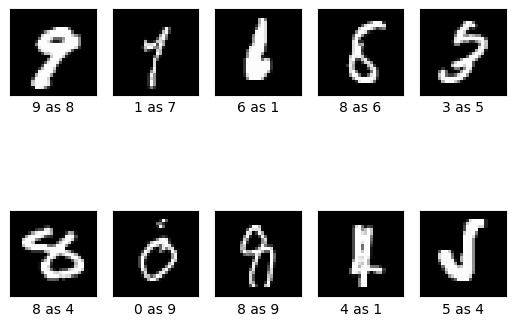

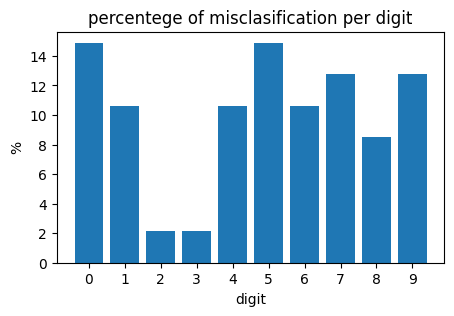

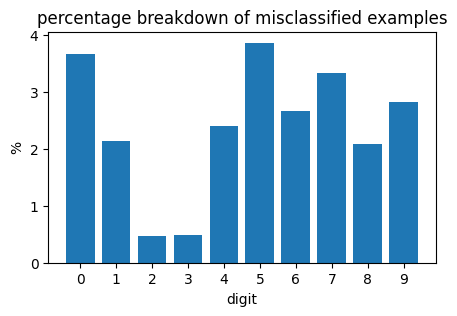

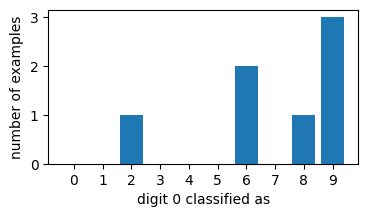

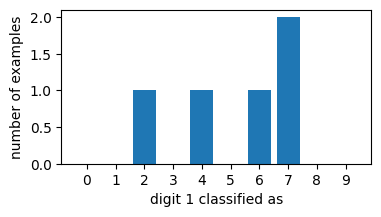

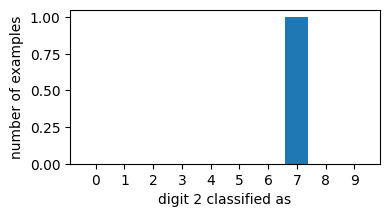

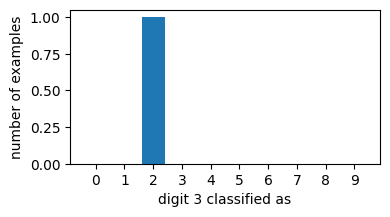

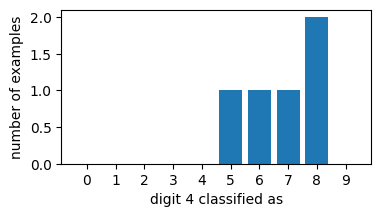

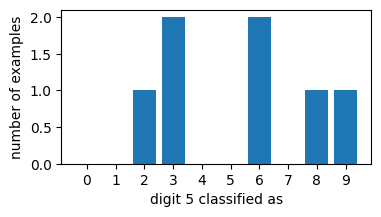

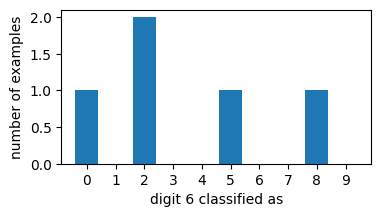

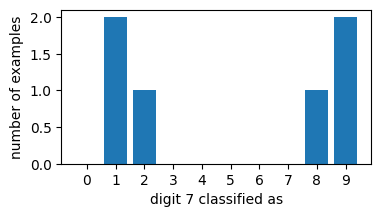

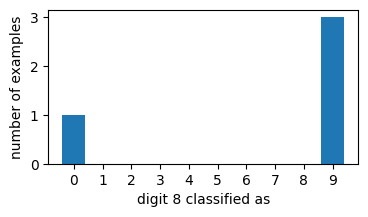

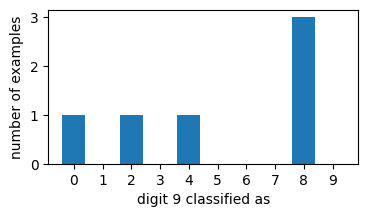

In [11]:
d, n_wrong = error_analysis(x, y, y_hat)
plot_misclassification_percentage_digits(d, n_wrong)
plot_breakdown_percentagies(d, y)
plot_misclassified_as(d)

## Visualize what the Covolutional layers output <a class='anchor' id='3'></a>

In [12]:
my_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 45, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 264)            │       304,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,246,536 (4.76 MB)

 Trainable params: 415,362 (1.58 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 830,726 (3.17 MB)

In [13]:
all_CNN_outputs = keras.Model(inputs = my_model.inputs, 
                           outputs = [layer.output for layer in my_model.layers if layer.name.startswith('re_lu')]
                           )

In [27]:
img_outputs = all_CNN_outputs(x_embedded_3dim[:10])

In [30]:
img_outputs[0].shape

TensorShape([10, 45, 45, 32])

In [48]:
def plot_one_layer_output(images):
    _, _, n_channels = images.shape
    # titles = [f'filter {i+1}' for i in range(n_channels)]
    
    n_cols = 8
    n_rows = n_channels//n_cols
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 6))

    # Flatten axes array for easy iteration
    axes = axes.ravel()

    for i in range(n_channels):
        axes[i].imshow(images[:,:,i], cmap='gray')  # Display the image
        # axes[i].set_title(titles[i])             # Set title for each image
        axes[i].axis('off')                  # Turn off axis

    # # Hide any extra axes (if there are any)
    # for j in range(i + 1, len(axes)):
    #     axes[j].axis('off')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

(45, 45, 32)


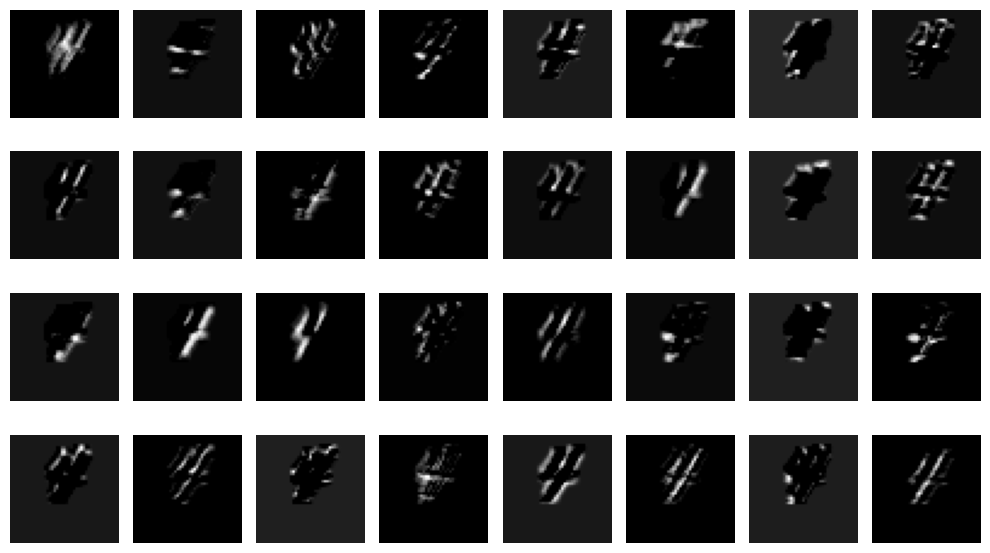

(19, 19, 64)


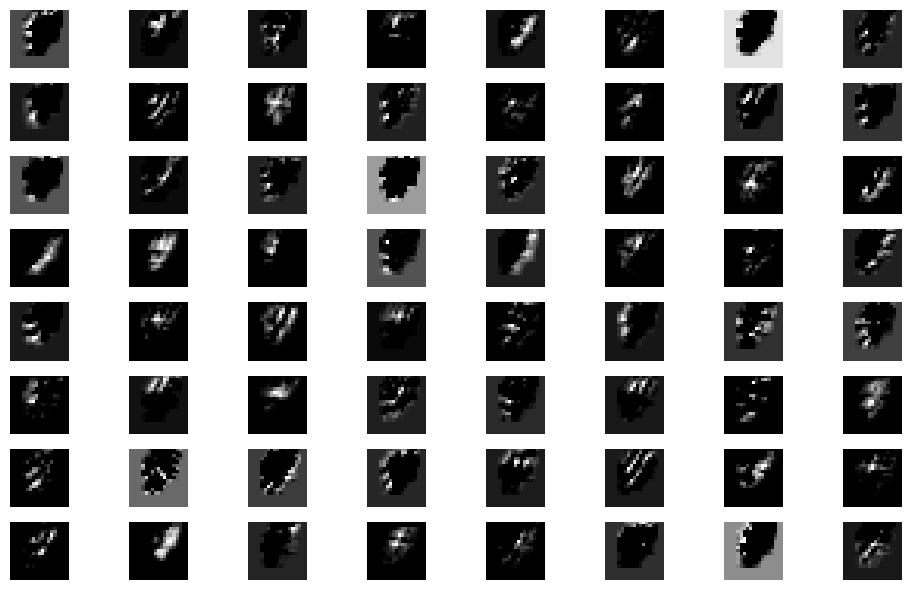

(7, 7, 128)


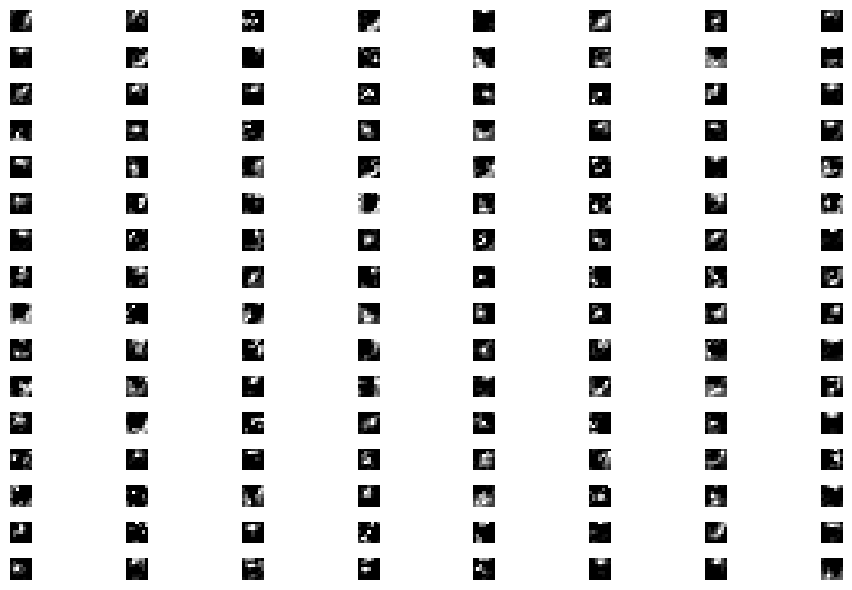

In [49]:
for b in img_outputs:
    image_set = b[0]
    print(image_set.shape)
    plot_one_layer_output(image_set)